# Book Recommendation System

## Objective
The objective of this project is to develop a book recommendation system that can accurately suggest books to users based on user rating histories (collaborative filtering), clustring, and book genre prediction (content-based). The system leverages Book Recommendation Dataset, which contains user demographics, book metadata, and ratings, aiming at recommending the most-likely interested books to the user and providing a personalized reading experience.

## Motivation
With the rise of web services, recommender systems are becoming more and more important in our daily lives. Right now, book recommendations are often made by looking at simple factors like what is popular/trending. This recommendation approach does not dig deep into readers' preferences, often leading to generic suggestions that don't quite hit the mark. This project aims at designing a book recommendation system that digs deeper by using information about users' rating histories and book metadata to make more personalized suggestions. A successful system can help users discover books they really love but might not have found, targeting a better user satisfaction.

# Explore the Data

## The Book Recommendation Dataset

The Book Recommendation Dataset (https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset) provides detailed data in user demographic, book information, and ratings. This provides a solid foundation for developing a personalized book recommendation system.

“The Book-Crossing dataset comprises 3 files:

### Users
Contains the users. Note that user IDs (User-ID) have been anonymized and map to integers. Demographic data is provided (Location, Age) if available. Otherwise, these fields contain NULL-values.

### Books
Books are identified by their respective ISBN. Invalid ISBNs have already been removed from the dataset. Moreover, some content-based information is given (Book-Title, Book-Author, Year-Of-Publication, Publisher), obtained from Amazon Web Services. Note that in case of several authors, only the first is provided. URLs linking to cover images are also given, appearing in three different flavors (Image-URL-S, Image-URL-M, Image-URL-L), i.e., small, medium, large. These URLs point to the Amazon web site.

### Ratings
Contains the book rating information. Ratings (Book-Rating) are either explicit, expressed on a scale from 1-10 (higher values denoting higher appreciation), or implicit, expressed by 0.”

In [292]:
!pip install swifter

In [293]:
#@title Import Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
import gensim
import re
from gensim.models import Word2Vec
import swifter

pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [294]:
#@title Mount Google Drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [295]:
#@title Read Data In

books = pd.read_csv("/content/drive/MyDrive/book-recommendation-dataset/Books.csv")
ratings = pd.read_csv("/content/drive/MyDrive/book-recommendation-dataset/Ratings.csv")
users = pd.read_csv("/content/drive/MyDrive/book-recommendation-dataset/Users.csv")

<ipython-input-295-08e09dd2ffcc>:3: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv("/content/drive/MyDrive/book-recommendation-dataset/Books.csv")


### Understand the Data

In [296]:
# Check shape
print(books.shape)
print(users.shape)
print(ratings.shape)

(271360, 8)
(278858, 3)
(1149780, 3)


In [297]:
books.head(5)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [298]:
ratings.head(5)

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [299]:
users.head(5)

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.00
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.00
4,5,"farnborough, hants, united kingdom",NaN


# Data Preprocessing

1. Drop the last several books columns containing image URLs which will not be useful for analysis.
2. Check and handle missing author and publisher value using mode.
3. Replace zero-value book ratings with non-zero ratings' median.
4. Replace NaN age value with ages' median.
5. Filter out invalid ages, non-positive years of publication.
6. Convert data type to integer (e.g. Age, Year-Of-Publication, Rating).
7. Merge dataframes.

## Preprocess Books

In [300]:
books.isnull().sum()

ISBN                   0
Book-Title             0
Book-Author            2
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64

In [301]:
# Drop unwanted columns
books.drop(['Image-URL-S', 'Image-URL-M', 'Image-URL-L'], axis=1, inplace=True)

# Year of Publication: Change NaN value to 0
books['Year-Of-Publication'] = pd.to_numeric(books['Year-Of-Publication'], errors='coerce').fillna(0)
books['Year-Of-Publication'] = books['Year-Of-Publication'].astype(int)

# Notice that some years are apparently invalid (e.g. year = 2050)
books.describe()

,Year-Of-Publication
count,271360.00
mean,1959.74
std,258.08
min,0.00
25%,1989.00
50%,1995.00
75%,2000.00
max,2050.00


In [302]:
# Filter out invalid years of publication, set valid years of publications between 1900-2024)
books = books[books['Year-Of-Publication'] >= 1900]
books = books[books['Year-Of-Publication'] <= 2024]

# Handle null values
books['Book-Author'].fillna(books['Book-Author'].mode()[0], inplace=True)
books['Publisher'].fillna(books['Publisher'].mode()[0], inplace=True)
books.info()

<class 'pandas.core.frame.DataFrame'>
Index: 266723 entries, 0 to 271359
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 266723 non-null  object
 1   Book-Title           266723 non-null  object
 2   Book-Author          266723 non-null  object
 3   Year-Of-Publication  266723 non-null  int64 
 4   Publisher            266723 non-null  object
dtypes: int64(1), object(4)
memory usage: 12.2+ MB


In [303]:
books.head(5)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


## Preprocess Ratings

In [304]:
ratings.isnull().sum()

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64

In [305]:
# Notice that more than half of the book ratings are 0 (which is invalid)
ratings.describe()

,User-ID,Book-Rating
count,1149780.00,1149780.00
mean,140386.40,2.87
std,80562.28,3.85
min,2.00,0.00
25%,70345.00,0.00
50%,141010.00,0.00
75%,211028.00,7.00
max,278854.00,10.00


In [306]:
# Replace 0 ratings with non-zero ratings' median
median_rating = ratings['Book-Rating'][ratings['Book-Rating'] != 0].median()
ratings['Book-Rating'].replace (0, median_rating, inplace=True)
ratings = ratings[ratings['Book-Rating'] > 0]
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [307]:
ratings.head(5)

,User-ID,ISBN,Book-Rating
0,276725,034545104X,8
1,276726,0155061224,5
2,276727,0446520802,8
3,276729,052165615X,3
4,276729,0521795028,6


## Preprocess Users

In [308]:
users.isnull().sum()

User-ID          0
Location         0
Age         110762
dtype: int64

In [309]:
# Handle null age values, replace null values with median age
users['Age'].fillna(users['Age'].median(), inplace=True)
users['Age'] = users['Age'].astype(int)
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   User-ID   278858 non-null  int64 
 1   Location  278858 non-null  object
 2   Age       278858 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 6.4+ MB


In [310]:
# Notice that some ages are apparently invalid (e.g. age = 0 and age = 244)
users.describe()

,User-ID,Age
count,278858.00,278858.00
mean,139429.50,33.66
std,80499.52,11.28
min,1.00,0.00
25%,69715.25,29.00
50%,139429.50,32.00
75%,209143.75,35.00
max,278858.00,244.00


In [311]:
# Filter out invalid ages (set valid ages between 5-100)
users = users[5 <= users['Age']]
users = users[users['Age'] <= 100]

In [312]:
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",32
1,2,"stockton, california, usa",18
2,3,"moscow, yukon territory, russia",32
3,4,"porto, v.n.gaia, portugal",17
4,5,"farnborough, hants, united kingdom",32


## Merge Dataframes

In [313]:
merged_df = pd.merge(books, ratings, on='ISBN')
df = pd.merge(merged_df, users, on="User-ID")
df.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,User-ID,Book-Rating,Location,Age
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,2,8,"stockton, california, usa",18
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,8,5,"timmins, ontario, canada",32
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,8,8,"timmins, ontario, canada",32
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,8,8,"timmins, ontario, canada",32
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,8,8,"timmins, ontario, canada",32


In [314]:
df.isnull().sum()

ISBN                   0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Publisher              0
User-ID                0
Book-Rating            0
Location               0
Age                    0
dtype: int64

In [315]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1012553 entries, 0 to 1012552
Data columns (total 9 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   ISBN                 1012553 non-null  object
 1   Book-Title           1012553 non-null  object
 2   Book-Author          1012553 non-null  object
 3   Year-Of-Publication  1012553 non-null  int64 
 4   Publisher            1012553 non-null  object
 5   User-ID              1012553 non-null  int64 
 6   Book-Rating          1012553 non-null  int64 
 7   Location             1012553 non-null  object
 8   Age                  1012553 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 69.5+ MB


In [316]:
df.describe()

,Year-Of-Publication,User-ID,Book-Rating,Age
count,1012553.00,1012553.00,1012553.00,1012553.00
mean,1995.30,140592.64,7.86,35.72
std,7.30,80468.35,1.14,10.59
min,1900.00,2.00,1.00,5.00
25%,1992.00,70415.00,8.00,31.00
50%,1997.00,141183.00,8.00,32.00
75%,2001.00,211391.00,8.00,41.00
max,2024.00,278854.00,10.00,100.00


# Data Visualization

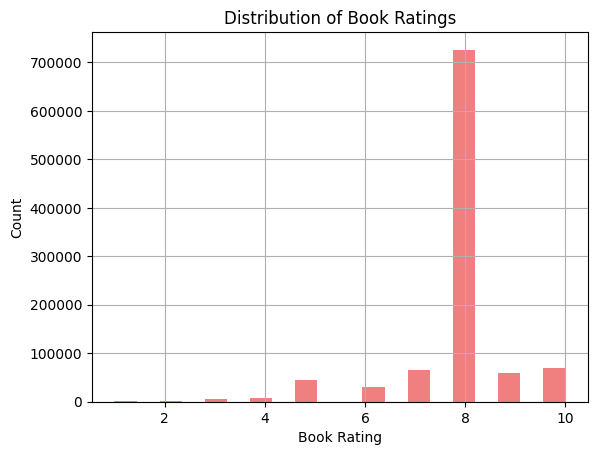

In [317]:
#@title Book Ratings
book_ratings = df['Book-Rating']
book_ratings.hist(bins=20, color='lightcoral')
plt.title('Distribution of Book Ratings')
plt.xlabel('Book Rating')
plt.ylabel('Count')
plt.show()

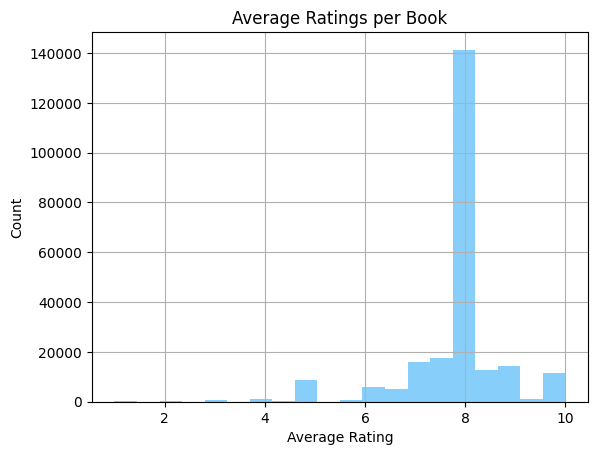

In [318]:
#@title Average Rating per Book
average_book_ratings = df.groupby('Book-Title')['Book-Rating'].mean()
average_book_ratings.hist(bins=20, color='lightskyblue')
plt.title('Average Ratings per Book')
plt.xlabel('Average Rating')
plt.ylabel('Count')
plt.show()

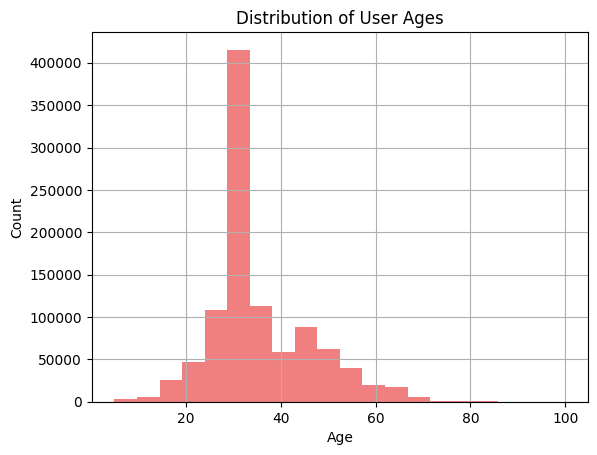

In [319]:
#@title User Ages
ages = df['Age']
ages.hist(bins=20, color='lightcoral')
plt.title('Distribution of User Ages')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

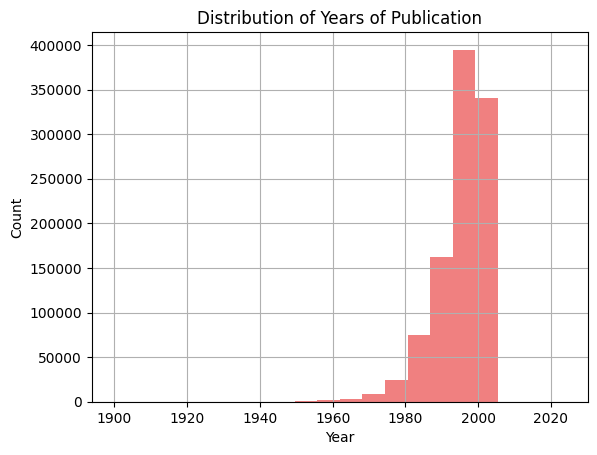

In [320]:
#@title Years of Publication
publication_years = df['Year-Of-Publication']
publication_years.hist(bins=20, color='lightcoral')
plt.title('Distribution of Years of Publication')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

#Filter Dataframe for Recommendation
After preprocessing, it can be observed that the DataFrame still remains considerably large, leading to a risk of exhausting RAM resources during analysis. Additionally, books with very few ratings and users who have provided only a limited number of ratings do not offer enough data points to effectively support the recommendation system. To address these issues, we should further refine our dataset to include only books that have received more than 100 ratings and users who have given more than 50 ratings to ensure we have more reliable data for analysis.

In [321]:
# Filter books that have more than 100 ratings
book_counts = df['Book-Title'].value_counts()
books_over_100_ratings = book_counts[book_counts > 100].index

# Filter users that have given more than 50 ratings
user_counts = df['User-ID'].value_counts()
users_over_50_ratings = user_counts[user_counts > 50].index

# Filter the DataFrame that contains only selected books and users
filtered_df = df[(df['Book-Title'].isin(books_over_100_ratings)) & (df['User-ID'].isin(users_over_50_ratings))]

In [322]:
filtered_df.describe()

,Year-Of-Publication,User-ID,Book-Rating,Age
count,103943.00,103943.00,103943.00,103943.00
mean,1997.19,139179.81,7.98,35.44
std,5.59,80710.76,0.97,9.81
min,1920.00,243.00,1.00,7.00
25%,1995.00,69042.00,8.00,30.00
50%,1999.00,138189.00,8.00,32.00
75%,2001.00,210792.00,8.00,40.00
max,2010.00,278843.00,10.00,100.00


In [323]:
filtered_df.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,User-ID,Book-Rating,Location,Age
19,0786868716,The Five People You Meet in Heaven,Mitch Albom,2003,Hyperion,11400,9,"ottawa, ontario, canada",49
20,0151008116,Life of Pi,Yann Martel,2002,Harcourt,11400,6,"ottawa, ontario, canada",49
21,0671021001,She's Come Undone (Oprah's Book Club),Wally Lamb,1998,Pocket,11400,8,"ottawa, ontario, canada",49
22,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant,1998,Picador USA,11400,7,"ottawa, ontario, canada",49
23,0446364193,Along Came a Spider (Alex Cross Novels),James Patterson,1993,Warner Books,11400,8,"ottawa, ontario, canada",49


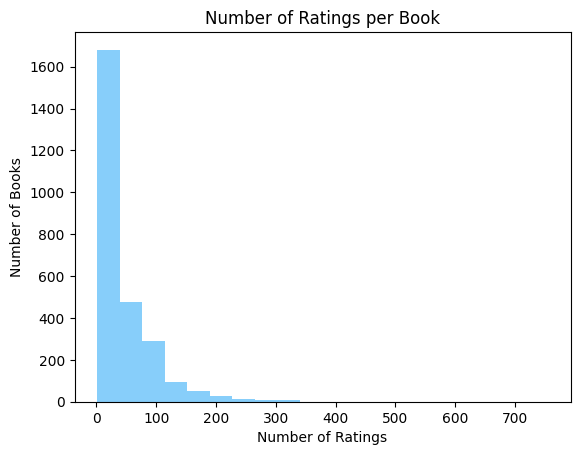

In [324]:
#@title Number of Ratings per Book
count_book_ratings = filtered_df['ISBN'].value_counts()
plt.hist(count_book_ratings, bins=20, color='lightskyblue')
plt.title('Number of Ratings per Book')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Books')
plt.show()

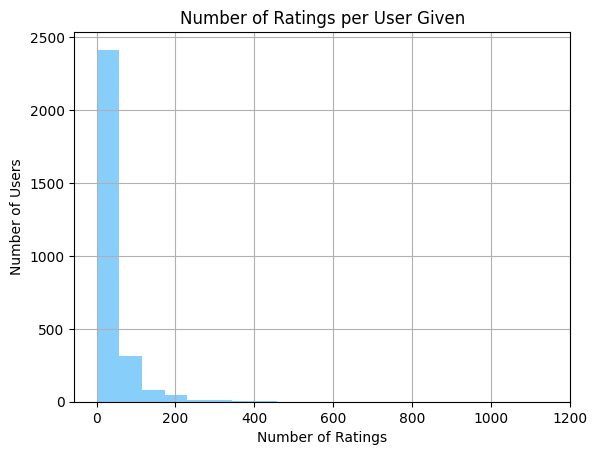

In [325]:
#@title Number of Ratings per User Given
count_user_ratings = filtered_df['User-ID'].value_counts()
count_user_ratings.hist(bins=20, color='lightskyblue')
plt.title('Number of Ratings per User Given')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')
plt.show()

# 1. Book Recommendation - Collaborative Filtering

Collaborative filtering is a popular technique in recommendation systems. It relies on the assumption that users who have agreed in the past will agree in the future about their preferences.

This method constructs a matrix, with books represented by rows and users by columns, while the matrix entries correspond to the ratings that users have given to books.Given the nature of the dataset, most entries in the matrix are missing and we fill the missing values with 0.

In [326]:
# Create a pivot table that organizes book ratings with books as rows and users as columns.
book_user_rating_pt = filtered_df.pivot_table(index='Book-Title',columns='User-ID',values='Book-Rating')
# Fill missing values with 0
book_user_rating_pt.fillna(0,inplace=True)
book_user_rating_pt.head(5)

User-ID,243,254,507,638,643,741,882,929,1211,1424,...,277928,277965,278026,278137,278144,278188,278418,278582,278633,278843
Book-Title,,,,,,,,,,,,,,,,,,,,,
1984,0.00,9.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1st to Die: A Novel,0.00,0.00,8.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
24 Hours,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2nd Chance,8.00,0.00,0.00,9.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4 Blondes,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


# 1.1 Cosine Similarity Method

Cosine similarity provides a measure of similarity between two non-zero vectors of an inner product space, it reflects the cosine of the angle between vectors, with a value 1 indicating perfect similarity and a value 0 indicating no similarity. In this method we calculate the cosine similarity between books based on the user ratings, which helps us understand which books are most similar.

In [327]:
# Compute cosine similarity between books based on user ratings.
# Cosine similarity measures how similar the books are in terms of user ratings.
similarity_scores = cosine_similarity(book_user_rating_pt)

In [328]:
def consine_similarity_recommendation(book_title):
  if book_title not in filtered_df['Book-Title'].values:
      print("Book title not found in the dataset.")
      return

  idx = np.where(book_user_rating_pt.index==book_title)[0][0]
  # Get the list of books based on similarity scores
  similar_books = sorted(list(enumerate(similarity_scores[idx])), key=lambda x:x[1], reverse=True)[1:10]

  res = []
  for idx, score in similar_books:
    book = []
    book_df = books[books['Book-Title'] == book_user_rating_pt.index[idx]].drop_duplicates('Book-Title')
    book_details = book_df[['Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher']].values.flatten().tolist()
    res.append(book_details)

  return res

In [329]:
consine_similarity_recommendation('24 Hours')

[['The Switch', 'Sandra Brown', 2001, 'Warner Vision'],
 ['Move to Strike', "Perri O'Shaughnessy", 2001, 'Island'],
 ['Moment of Truth', 'Lisa Scottoline', 2001, 'HarperTorch'],
 ['The Alienist', 'Caleb Carr', 1995, 'Bantam Books'],
 ['The Sigma Protocol', 'Robert Ludlum', 2002, "St. Martin's Paperbacks"],
 ['Mystic River', 'Dennis Lehane', 2002, 'HarperTorch'],
 ['B Is for Burglar (Kinsey Millhone Mysteries (Paperback))',
  'Sue Grafton',
  1986,
  'Bantam'],
 ['The Simple Truth', 'David Baldacci', 1999, 'Warner Books'],
 ['The Blue Nowhere : A Novel', 'Jeffery Deaver', 2002, 'Pocket']]

In [330]:
consine_similarity_recommendation('1984')

[['Brave New World', 'Aldous Huxley', 1989, 'Harpercollins'],
 ['Animal Farm', 'George Orwell', 2004, 'Signet'],
 ['Lord of the Flies', 'William Gerald Golding', 1959, 'Perigee Trade'],
 ['The Catcher in the Rye', 'J.D. Salinger', 1991, 'Little, Brown'],
 ['Fahrenheit 451', 'Ray Bradbury', 1994, 'Distribooks Inc'],
 ['Word Freak: Heartbreak, Triumph, Genius, and Obsession in the World of Competitive Scrabble Players',
  'Stefan Fatsis',
  2002,
  'Penguin Books'],
 ['Me Talk Pretty One Day', 'David Sedaris', 2001, 'Back Bay Books'],
 ['To Kill a Mockingbird', 'Harper Lee', 1988, 'Little Brown &amp; Company'],
 ["The Hitchhiker's Guide to the Galaxy", 'Douglas Adams', 1982, 'Pocket']]

# 1.2 KNN Method

The K-Nearest Neighbors (KNN) is an algorithm used to identify items with the most similarity to a query item. In the context of our Book Recommendation System, it is used to find the k books that have the closest user rating patterns to the given book. The neighbors are selected based on their proximity to the given book using the distance metric defined by the algorithm.

In [331]:
# Use NearestNeighbors for finding k-nearest items
knn_model = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=5, n_jobs=-1)
knn_model.fit(book_user_rating_pt.values)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1)

In [332]:
def knn_recommendation(book_title, model, data, n_recommendations):
  if book_title not in data.index:
    print("Book title not found in the dataset.")
    return

  book_idx = data.index.get_loc(book_title)
  distances, indices = model.kneighbors(data.iloc[book_idx, :].values.reshape(1, -1), n_neighbors=n_recommendations + 1)

  res = []
  for i in range(1, len(distances.flatten())):
    book_info = filtered_df[filtered_df['Book-Title'] == data.index[indices.flatten()[i]]].drop_duplicates('Book-Title')
    book_details = book_info[['Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher']].values.flatten().tolist()
    res.append(book_details)

  return res

In [333]:
knn_recommendation('24 Hours', knn_model, book_user_rating_pt, 10)

[['The Switch', 'Sandra Brown', 2001, 'Warner Vision'],
 ['Move to Strike', "Perri O'Shaughnessy", 2001, 'Island'],
 ['Moment of Truth', 'Lisa Scottoline', 2001, 'HarperTorch'],
 ['The Alienist', 'Caleb Carr', 1995, 'Bantam Books'],
 ['The Sigma Protocol', 'Robert Ludlum', 2002, "St. Martin's Paperbacks"],
 ['Mystic River', 'Dennis Lehane', 2002, 'HarperTorch'],
 ['B Is for Burglar (Kinsey Millhone Mysteries (Paperback))',
  'Sue Grafton',
  1986,
  'Bantam'],
 ['The Simple Truth', 'David Baldacci', 1999, 'Warner Books'],
 ['The Blue Nowhere : A Novel', 'Jeffery Deaver', 2002, 'Pocket'],
 ['A Map of the World', 'Jane Hamilton', 1999, 'Anchor Books/Doubleday']]

In [334]:
knn_recommendation('1984', knn_model, book_user_rating_pt, 10)

[['Brave New World', 'Aldous Huxley', 1989, 'Harpercollins'],
 ['Animal Farm', 'George Orwell', 2004, 'Signet'],
 ['Lord of the Flies', 'William Gerald Golding', 1959, 'Perigee Trade'],
 ['The Catcher in the Rye', 'J.D. Salinger', 1991, 'Little, Brown'],
 ['Fahrenheit 451', 'Ray Bradbury', 1994, 'Distribooks Inc'],
 ['Word Freak: Heartbreak, Triumph, Genius, and Obsession in the World of Competitive Scrabble Players',
  'Stefan Fatsis',
  2002,
  'Penguin Books'],
 ['Me Talk Pretty One Day', 'David Sedaris', 2001, 'Back Bay Books'],
 ['To Kill a Mockingbird', 'Harper Lee', 1988, 'Little Brown &amp; Company'],
 ["The Hitchhiker's Guide to the Galaxy", 'Douglas Adams', 1982, 'Pocket'],
 ['Fast Food Nation: The Dark Side of the All-American Meal',
  'Eric Schlosser',
  2002,
  'Perennial']]

# 2. Book Recommendation - Clustering
The clustering algorithm categorizes users into segments based on their book ratings. This approach treats the recommendation as a classification problem. Users in the same cluster share similar preferences and behaviors, and are more alike to each other than in other clusters. By utilizing the clustering algorithm, the system can recommend books that resonate with the specific interests of each user group.

In [335]:
# Create a pivot table that organizes book ratings with users as rows and books as columns.
user_book_rating_pt = filtered_df.pivot_table(index='User-ID', columns='Book-Title', values='Book-Rating')

# Fill missing values with 0
user_book_rating_pt.fillna(0,inplace=True)

In [336]:
# Perform clustering and assign users to clusters
kmeans = KMeans(n_clusters=100, random_state=42).fit(user_book_rating_pt)
user_book_rating_pt['Cluster'] = kmeans.labels_

In [337]:
user_book_rating_pt.head(5)

Book-Title,1984,1st to Die: A Novel,24 Hours,2nd Chance,4 Blondes,A Beautiful Mind: The Life of Mathematical Genius and Nobel Laureate John Nash,A Bend in the Road,A Case of Need,"A Child Called \It\"": One Child's Courage to Survive""",A Civil Action,...,"Wizard and Glass (The Dark Tower, Book 4)",Women Who Run with the Wolves,"Word Freak: Heartbreak, Triumph, Genius, and Obsession in the World of Competitive Scrabble Players",Wuthering Heights,Year of Wonders,You Belong To Me,Zen and the Art of Motorcycle Maintenance: An Inquiry into Values,Zoya,"\O\"" Is for Outlaw""",Cluster
User-ID,,,,,,,,,,,,,,,,,,,,,
243,0.00,0.00,0.00,8.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,38
254,9.00,0.00,0.00,0.00,0.00,0.00,8.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,74
507,0.00,8.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,50
638,0.00,0.00,0.00,9.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,38
643,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,50


In [338]:
def cluster_recommendation(user_id, num_recommendations=5):
  if user_id not in user_book_rating_pt.index:
    return f"User ID {user_id} not found."\

  # Find the cluster of the user
  cluster = user_book_rating_pt.loc[user_id, 'Cluster']
  # Get all users in the cluster
  cluster_users = user_book_rating_pt[user_book_rating_pt['Cluster'] == cluster]

  # Get average book ratings of that cluster
  book_ratings = cluster_users.replace(0, pd.NA).mean().sort_values(ascending=False)

  # Filter out books the given user has already rated
  books_rated = user_book_rating_pt.columns[user_book_rating_pt.loc[user_id] > 0]
  recommendations = book_ratings.drop(labels=books_rated).head(num_recommendations)

  print("Books enjoyed by users with similar tastes:")
  return recommendations

In [339]:
cluster_recommendation(2276, 10)

Books enjoyed by users with similar tastes:


Book-Title
The Little Prince                                               10.00
Chicken Soup for the Teenage Soul (Chicken Soup for the Soul)   10.00
Siddhartha                                                       9.50
The Last Time They Met : A Novel                                 9.00
Forever... : A Novel of Good and Evil, Love and Hope             9.00
Atlas Shrugged                                                   9.00
Catering to Nobody                                               9.00
Naked                                                            9.00
Sisterhood of the Traveling Pants                                9.00
Lucky Man: A Memoir                                              9.00
dtype: object

In [340]:
cluster_recommendation(3363, 10)

Books enjoyed by users with similar tastes:


Book-Title
Dark Rivers of the Heart                                                 10.00
Slaughterhouse Five or the Children's Crusade: A Duty Dance With Death    9.00
The Sparrow                                                               9.00
Mind Prey                                                                 9.00
Dragon Tears                                                              9.00
Where the Red Fern Grows                                                  8.89
Charlotte's Web (Trophy Newbery)                                          8.83
Interpreter of Maladies                                                   8.77
Ender's Game (Ender Wiggins Saga (Paperback))                             8.69
Anne Frank: The Diary of a Young Girl                                     8.69
dtype: object

# 3. Book Recommendation - Content-Based Using Word2Vec

This approach uses the Word2Vec model to perform content-based filtering. Word2Vec is utilized to understand and quantify the semantic relationships between words within book titles and their associated genres.

By training the Word2Vec model on the book titles text data, this approach generates word embeddings that capture the essence of each book's thematic content, and predicts the genre of each book.

This recommendation approach identifies the top 10 books with the highest average ratings within the same genre as the given book.

In [341]:
def clean_text(text):
  text = re.sub(r'[^a-zA-Z\s]', '', text).lower()
  return text

In [342]:
# Define genres
genres = ['Romance', 'Mystery', 'Science', 'History', 'Fiction', 'Horror', 'Thriller', 'Other']

# Split the title words, prepare words for training
words = [[genre.lower() for genre in genres]]
for title in filtered_df['Book-Title']:
  words.append(clean_text(title).split())

# Train the Word2Vec model
word2vec_model = Word2Vec(words, vector_size=100, window=5, min_count=1, sg=1)

In [343]:
def get_most_similar(title_vector):
  # Initialize max similarity and result
  max_similarity = float('-inf')
  res = None

  # Iterate over genres and find the most similar genre
  for genre in genres:
    genre_vector = word2vec_model.wv[genre.lower()]
    similarity = cosine_similarity([title_vector], [genre_vector])[0][0]
    if similarity > max_similarity:
      res = genre
      max_similarity = similarity
  return res

def predict_genre(title):
  # Clean up the title and split into words
  # Filter title words that are present in the Word2Vec model vocabulary
  words = clean_text(title).split()
  title_words = []
  for word in words:
    if word in word2vec_model.wv:
      title_words.append(word)

  # If there is no word left, return 'Other' genre
  if not title_words:
    return 'Other'

  # Calculate average vector of the title words
  avg_vector = sum([word2vec_model.wv[w] for w in title_words]) / len(title_words)

  # Find the most similar genre
  return get_most_similar(avg_vector)

In [344]:
predict_genre('A Map of the World')

'History'

In [345]:
predict_genre('Horror')

'Horror'

In [346]:
# Apply the function and get all books predicted
filtered_df['Genre'] = filtered_df['Book-Title'].swifter.apply(predict_genre)
filtered_df.head()

Pandas Apply:   0%|          | 0/103943 [00:00<?, ?it/s]

<ipython-input-346-53227ec46956>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Genre'] = filtered_df['Book-Title'].swifter.apply(predict_genre)


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,User-ID,Book-Rating,Location,Age,Genre
19,0786868716,The Five People You Meet in Heaven,Mitch Albom,2003,Hyperion,11400,9,"ottawa, ontario, canada",49,History
20,0151008116,Life of Pi,Yann Martel,2002,Harcourt,11400,6,"ottawa, ontario, canada",49,History
21,0671021001,She's Come Undone (Oprah's Book Club),Wally Lamb,1998,Pocket,11400,8,"ottawa, ontario, canada",49,Mystery
22,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant,1998,Picador USA,11400,7,"ottawa, ontario, canada",49,Fiction
23,0446364193,Along Came a Spider (Alex Cross Novels),James Patterson,1993,Warner Books,11400,8,"ottawa, ontario, canada",49,Horror


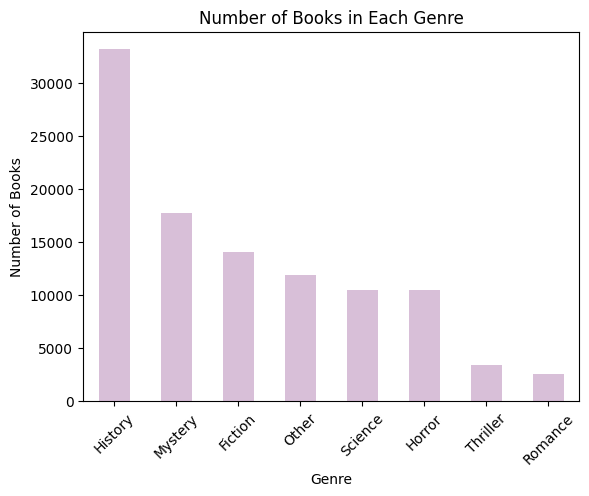

In [347]:
#@title Number of Books in Each Genre
count_genres = filtered_df.groupby('Genre')['Book-Title'].count().sort_values(ascending=False)
count_genres.plot(kind='bar', color='thistle')
plt.title('Number of Books in Each Genre')
plt.xlabel('Genre')
plt.ylabel('Number of Books')
plt.xticks(rotation=45)
plt.show()

In [348]:
def content_based_recommendation(book_title):
  if book_title not in filtered_df['Book-Title'].values:
    print("Book title not found in the dataset.")
    return

  genre = filtered_df[filtered_df['Book-Title'] == book_title]['Genre'].iloc[0]
  books_same_genre = filtered_df[filtered_df['Genre'] == genre].groupby('Book-Title')['Book-Rating'].mean().sort_values(ascending=False)

  recommend_books = books_same_genre.head(10).index.tolist()

  res = []
  for title in recommend_books:
    book_info = filtered_df[(filtered_df['Book-Title'] == title) & (filtered_df['Genre'] == genre)].drop_duplicates('Book-Title')
    book_details = book_info[['Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher']].values.flatten().tolist()
    res.append(book_details)

  print(f"More books in genre '{genre}':")
  return res

In [349]:
content_based_recommendation('Animal Farm')

More books in genre 'Mystery':


[["Ender's Game (Ender Wiggins Saga (Paperback))",
  'Orson Scott Card',
  1994,
  'Tor Books'],
 ['Anne of Avonlea (Anne of Green Gables Novels (Paperback))',
  'L.M. MONTGOMERY',
  1984,
  'Bantam Classics'],
 ['Anne of Green Gables (Anne of Green Gables Novels (Paperback))',
  'L.M. MONTGOMERY',
  1982,
  'Bantam Classics'],
 ['Dune (Remembering Tomorrow)', 'Frank Herbert', 1996, 'ACE Charter'],
 ['Night', 'Elie Wiesel', 1982, 'Bantam Books'],
 ['Fingersmith', 'Sarah Waters', 2002, 'Riverhead Books'],
 ['One for the Money (A Stephanie Plum Novel)',
  'Janet Evanovich',
  2003,
  "St. Martin's Paperbacks"],
 ['High Five (A Stephanie Plum Novel)',
  'Janet Evanovich',
  2000,
  "St. Martin's Paperbacks"],
 ['Year of Wonders', 'Geraldine Brooks', 2002, 'Penguin Books'],
 ['Seven Up (A Stephanie Plum Novel)',
  'Janet Evanovich',
  2001,
  "St. Martin's Press"]]